# Plotting script for MHW and DHWs 

In [42]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [ ]:
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client() # Client(threads_per_worker=1) # why?
client


In [44]:
def load_and_mean(file_path, var):
    """
    Load a dataset from a NetCDF file and compute the mean for a specified variable.
    
    Parameters:
        file_path (str): Path to the NetCDF file containing the dataset.
        var (str): Name of the variable in the dataset for which the mean is to be computed.
        
    Returns:
        mean_data (xarray.DataArray): The mean values of the specified variable.
    """
    ds = xr.open_dataset(file_path)
    mean_data = ds[var]
    return mean_data #, ds['xt_ocean'], ds['yt_ocean']

# List of periods and variables
periods = ['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
base_period = 'GW1p2'


# Load datasets and compute means
means = {}
coords = {}
#data = means[(var, period)]
#vmin = np.nanmin(data.values)
#vmax = np.nanmax(data.values)


##  My plotting script

In [45]:
## %%time
def all_plot(variable, title, base_period,lev1,lev2,scale):
#    variable='duration'
    print(variable )
    print(periods)
    fig, axes = plt.subplots(5, 2, figsize=(22, 24), 
            subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
            gridspec_kw={'hspace': 0.2, 'wspace': 0.0})
#            gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
    fig.suptitle(title, fontsize=18, y=0.92, weight='bold')

    for i, period in enumerate(periods):
        print(period) 
        ax = axes[i, 0]
        data=means[variable,period]*scale
        image=data.plot(ax=ax,cmap=plt.cm.Reds,transform=ccrs.PlateCarree(),
           levels=lev1, add_colorbar=False )
        if variable == 'OAR' :
           data[0,:,:].plot.contour(ax=ax,transform=ccrs.PlateCarree(),
           levels=[1], add_colorbar=False, colors='black' )
            
        ax.set_title(f'{period} (Mean)', fontsize=14)
        ax.set_xlabel(' ') #Longitude East')
        ax.set_ylabel(' ') #Latitude')
        ax.coastlines()
        ax.set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())  
        ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
        ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        ax.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
        cbar = fig.colorbar( image, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
        cbar.set_label(title)
# second column
        if period != base_period:
            ax = axes[i, 1]
            diff_data = data - means[(variable, base_period)]*scale
            image=diff_data.plot(ax=ax,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(),
               levels=lev2, add_colorbar=False )
            ax.set_title(f'{period} (Difference)', fontsize=14)
            ax.coastlines()
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())  
            ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
            ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
            ax.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
            cbar = fig.colorbar( image, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
            cbar.set_label(f'{title} Change')
    
    # Remove the unused subplot in the first row, second column
    fig.delaxes(axes[0, 1])

    plt.savefig(f'{variable}.png')
    plt.show()

def get_data(file_template,variables,periods,mean,astr):
# Load datasets and compute means
    means = {}
    coords = {}
    for period in periods:
        for var in variables:
            file_path = file_template.format(period=period)
#            mean_data, lon, lat = load_and_mean(file_path, var)
            mean_data = load_and_mean(file_path, var)
            if mean == True: 
                means[(var, period)] = mean_data.mean(astr)
            else :
                means[(var, period)] = mean_data
#            coords[(var, period)] = (lon, lat)
    return means,coords


dhw_amax
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
GW1p5
GW2p0
GW3p0
GW4p0


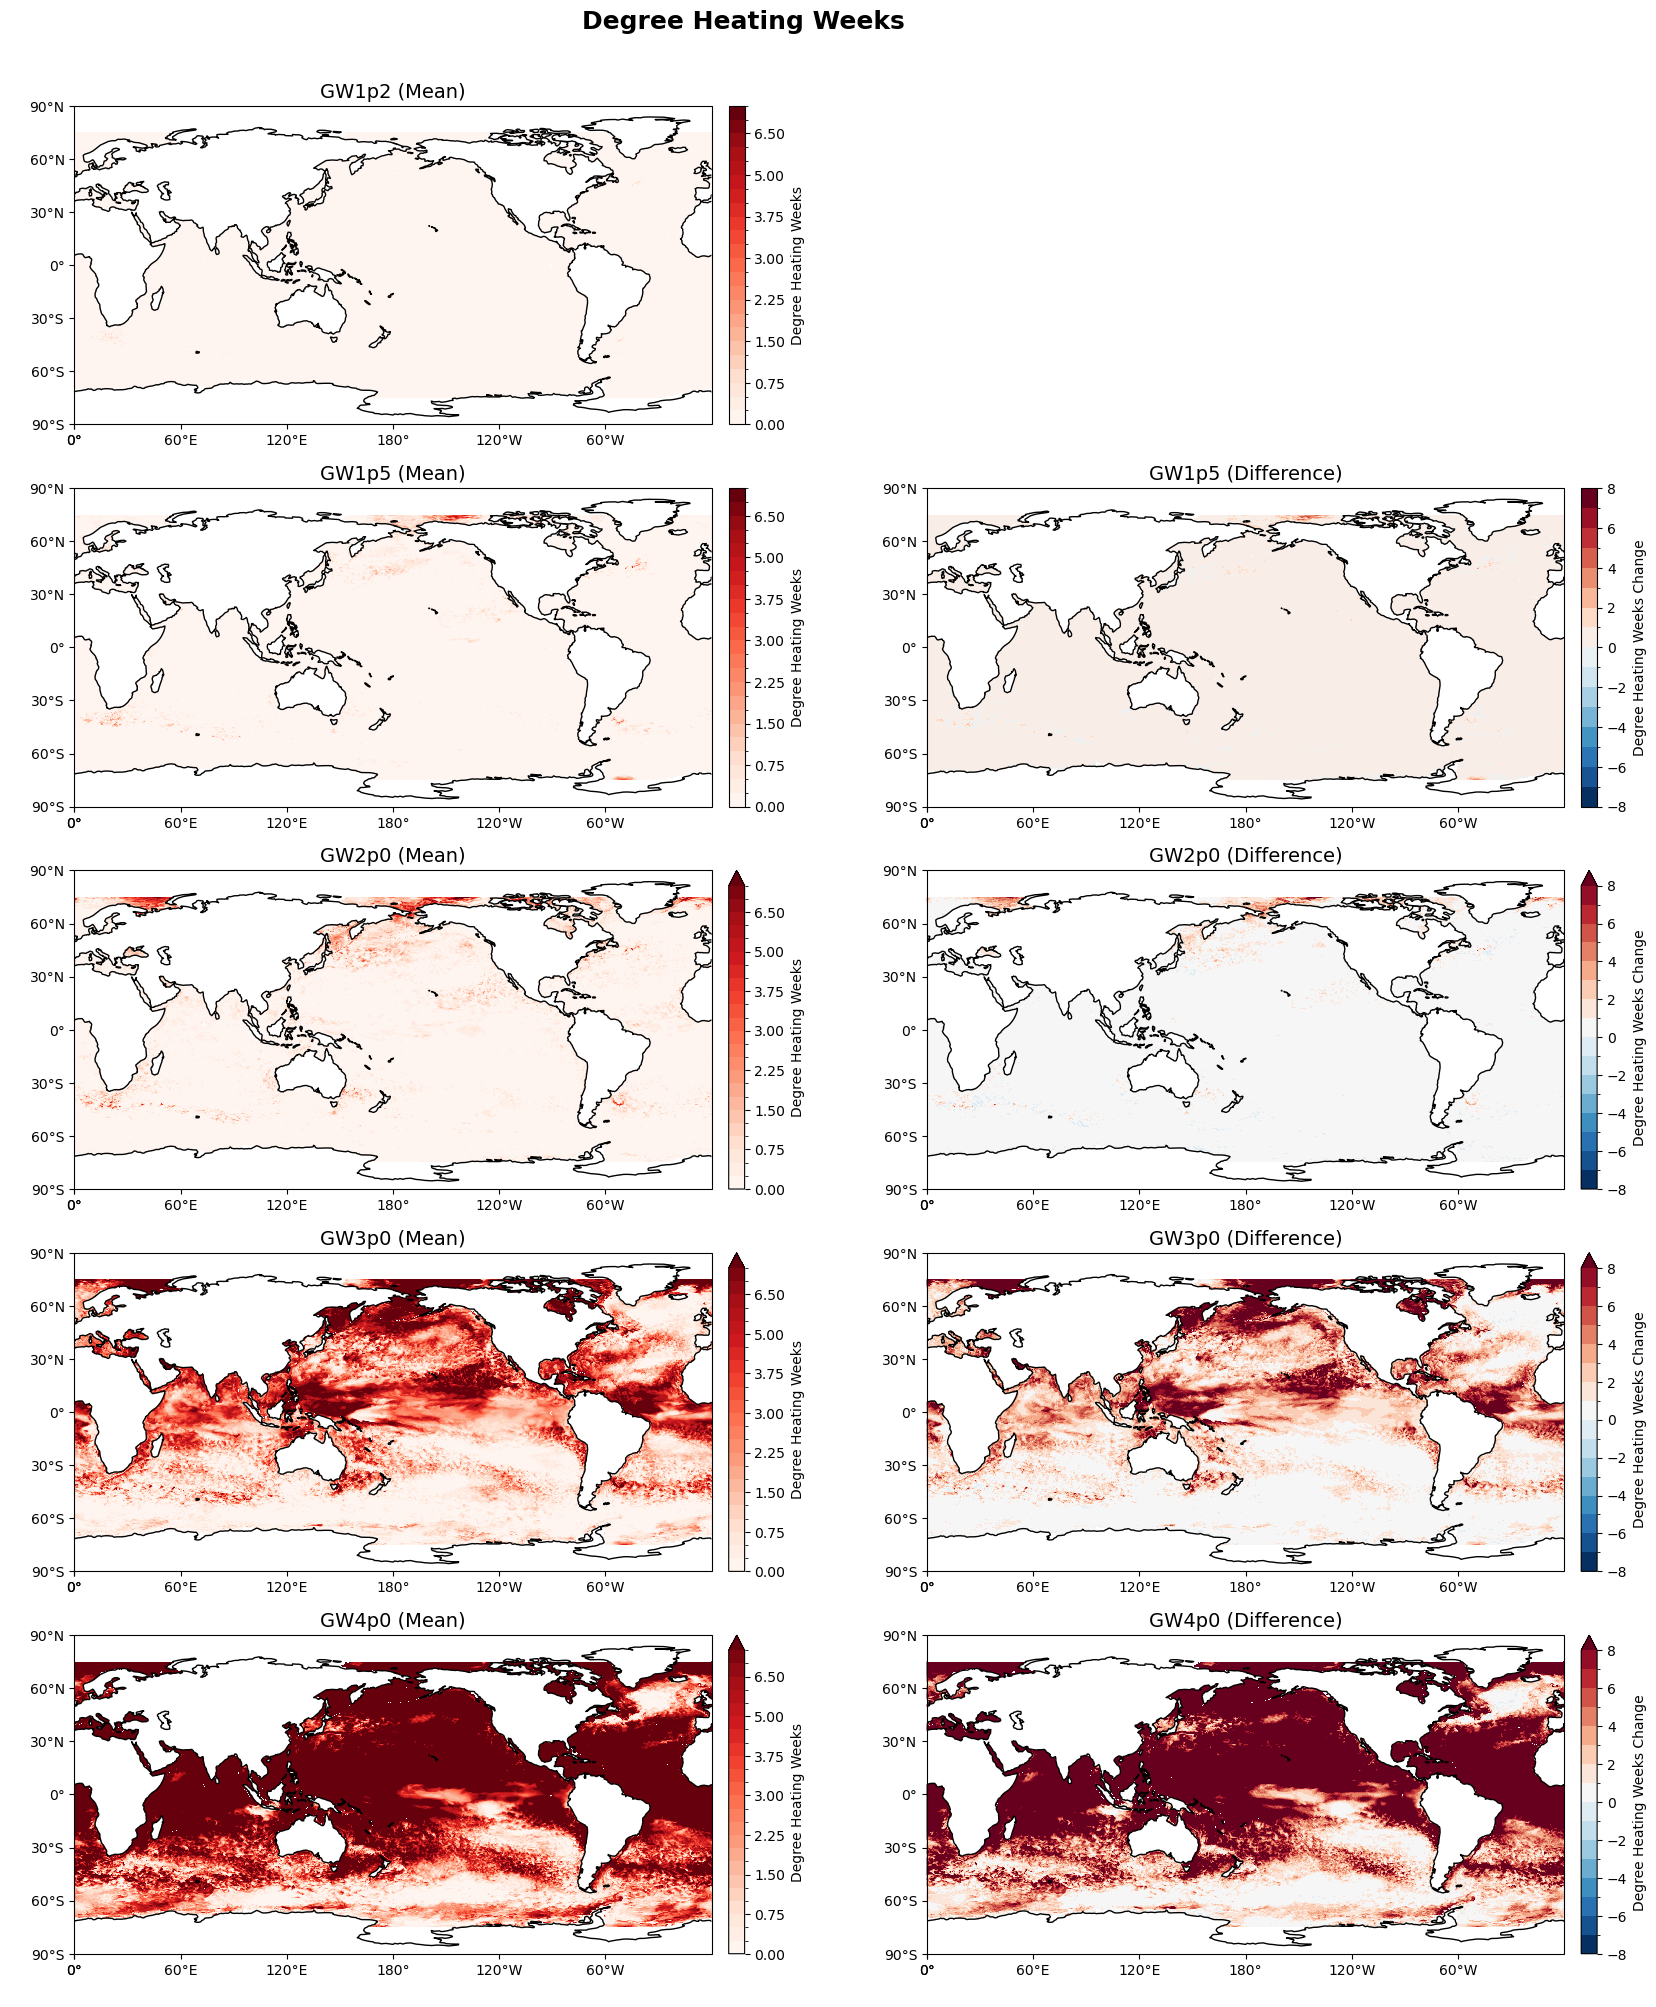

CPU times: user 4min 51s, sys: 1min 49s, total: 6min 41s
Wall time: 4min 26s


In [46]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/{period}_dhw.nc"
variables = ['dhw_amax']

means,coords=get_data(file_template,variables,periods,True,'year')
means['dhw_amax','GW1p2']

a1=np.arange(0,4,.25)
a2=np.arange(4,8,.5)
lev1=np.concatenate([a1, a2])
lev2=range(-8,9,1)
all_plot('dhw_amax','Degree Heating Weeks',base_period,lev1,lev2,1)

temp
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
GW1p5
GW2p0
GW3p0
GW4p0


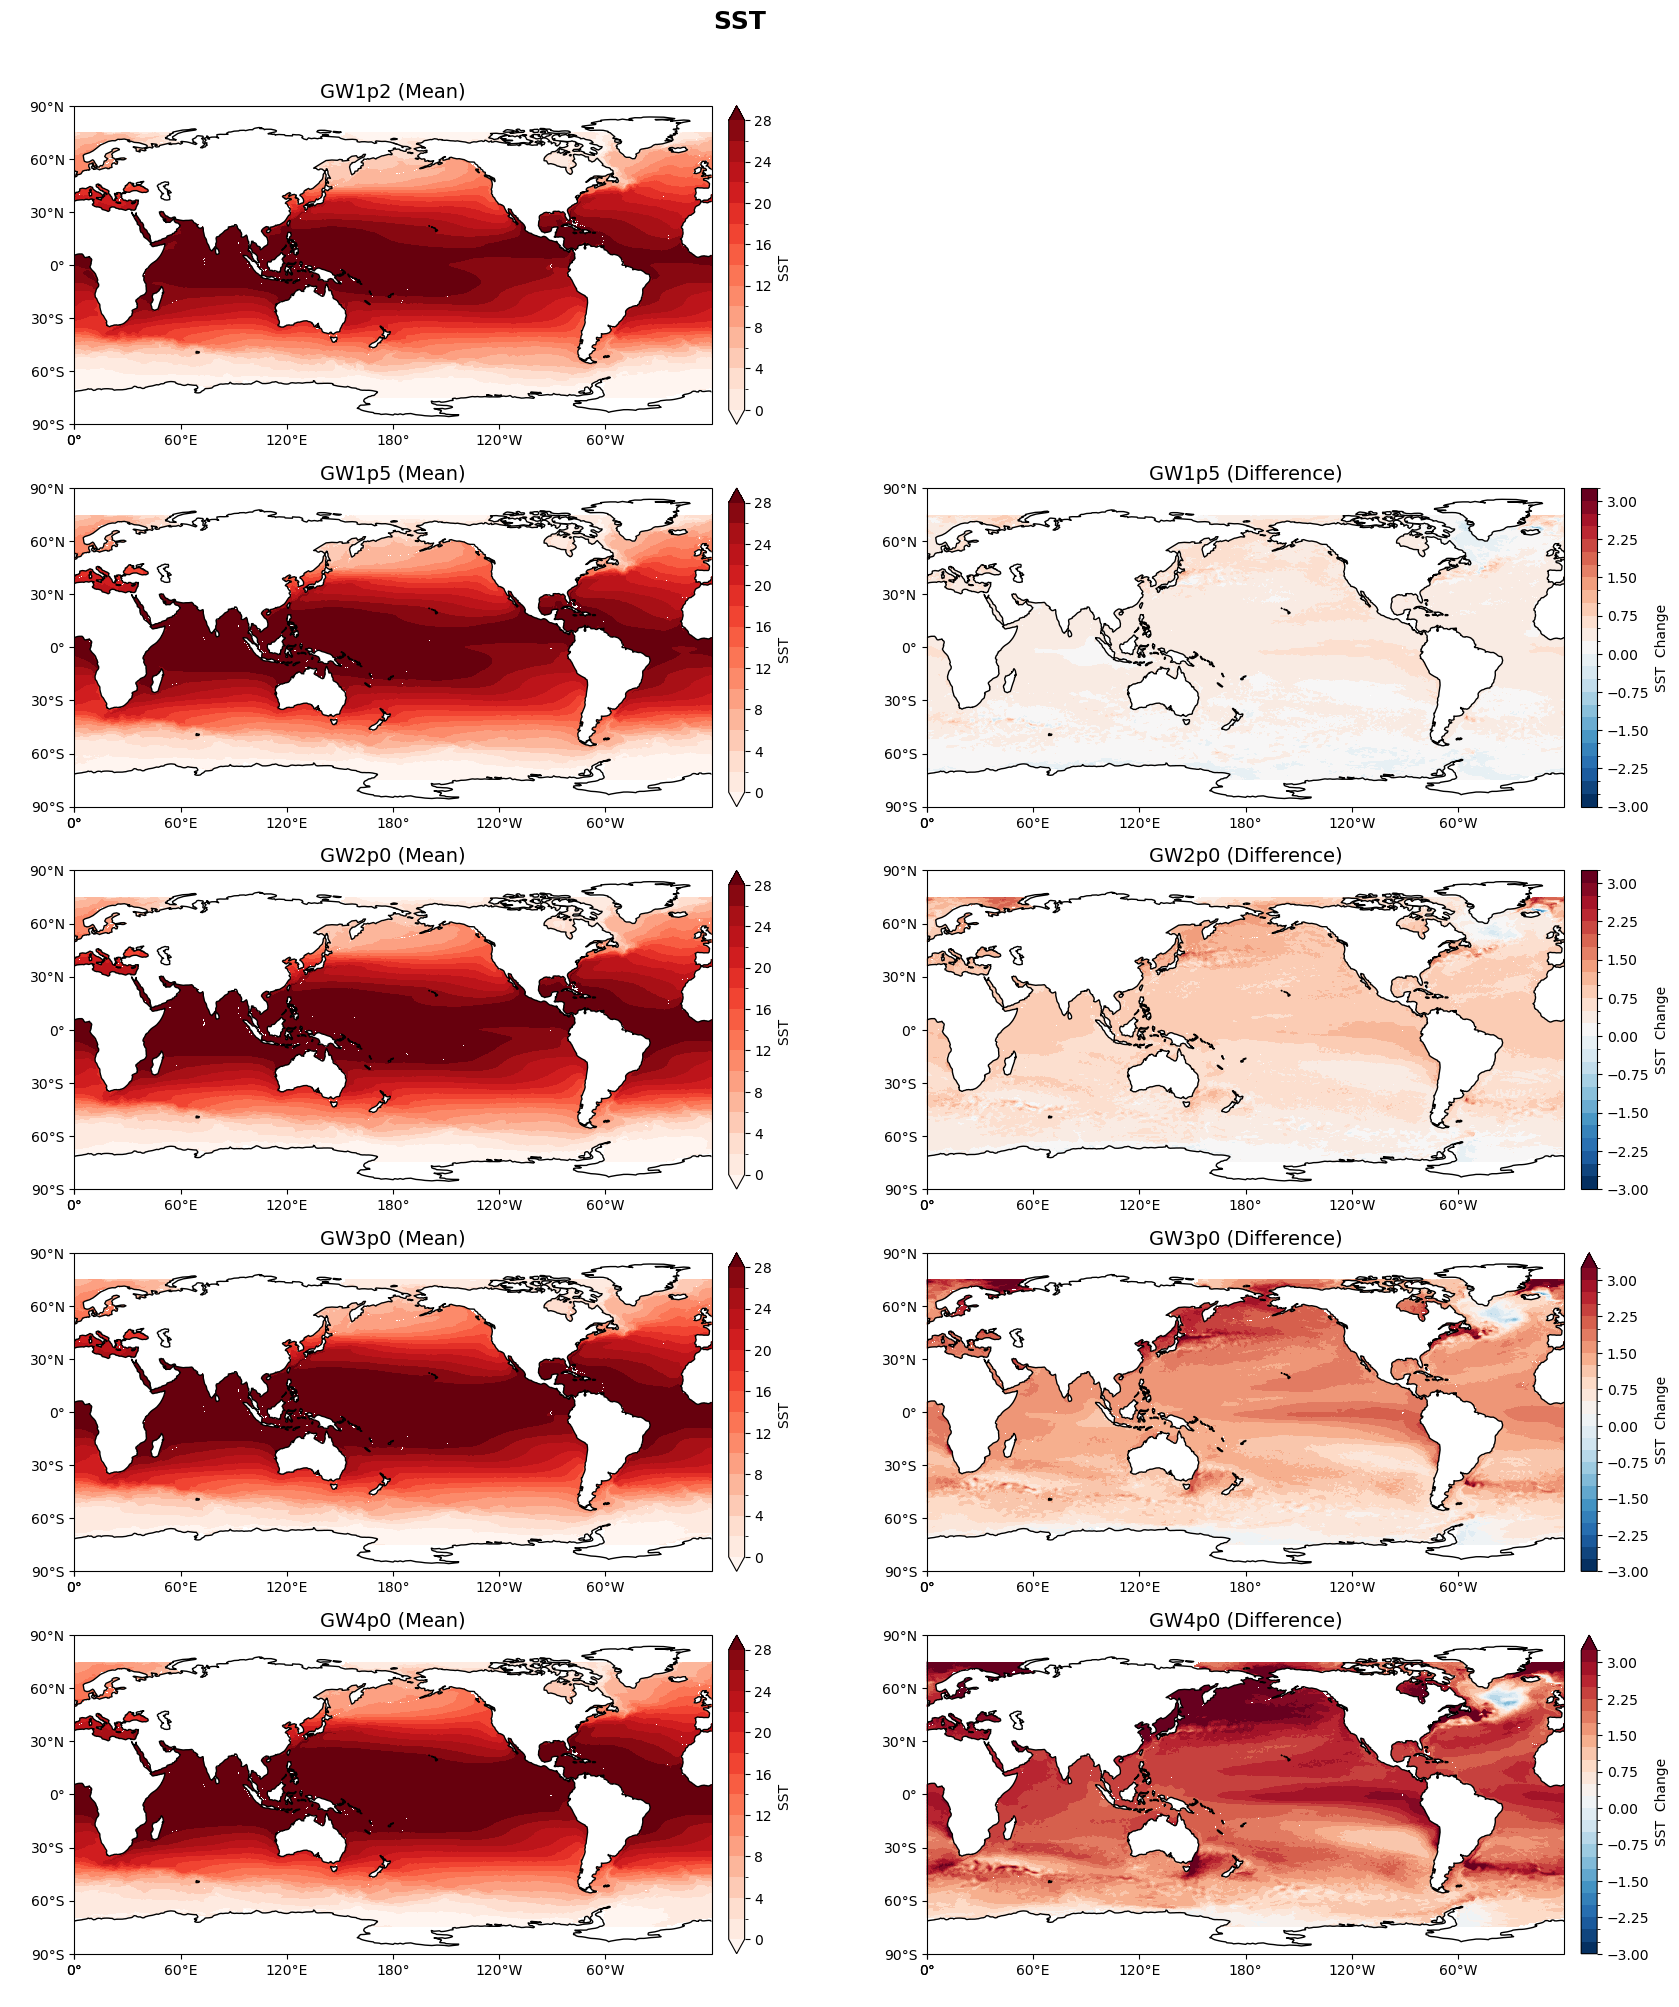

CPU times: user 4min 52s, sys: 1min 51s, total: 6min 43s
Wall time: 4min 29s


In [47]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/sst_climatology_{period}.nc"
variables = ['temp']
means,coords=get_data(file_template,variables,periods,True,'month')
#
lev1=np.arange(0,30,2)
lev2=np.arange(-3,3.5,0.25)
all_plot('temp','SST ',base_period,lev1,lev2,1)

pprod_gross_2d
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
GW1p5
GW2p0
GW3p0
GW4p0


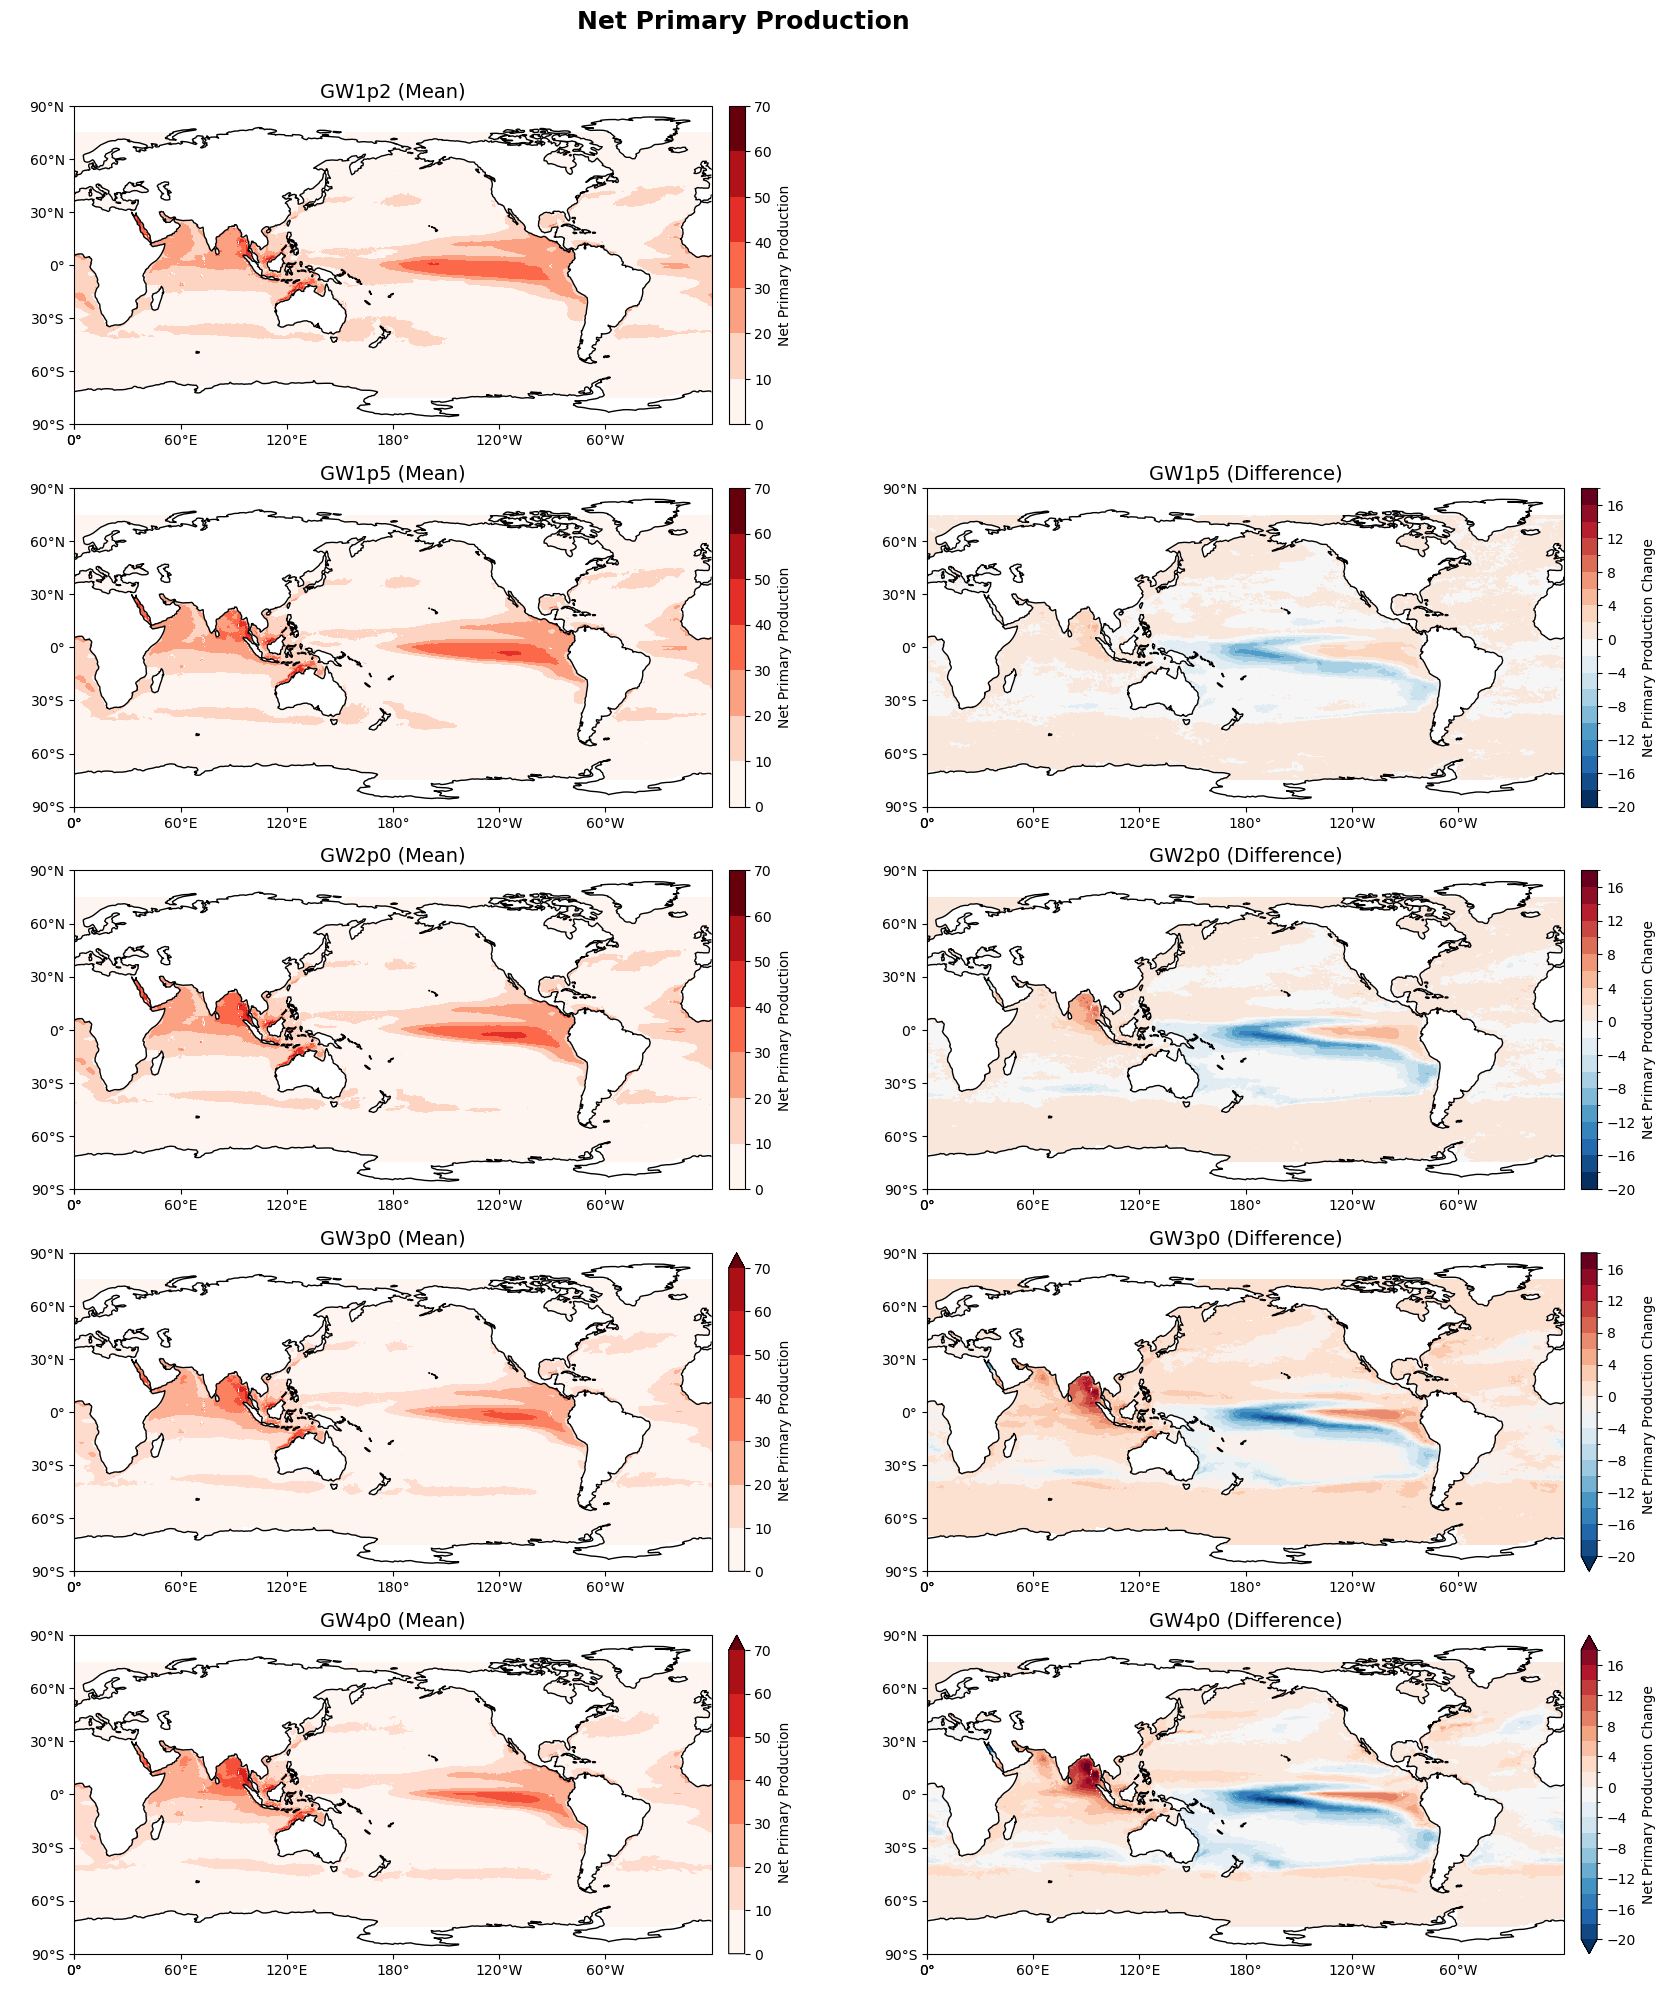

CPU times: user 4min 47s, sys: 1min 48s, total: 6min 35s
Wall time: 4min 21s


In [48]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/pprod_gross_2d_climatology_{period}.nc"
variables = ['pprod_gross_2d']
means,coords=get_data(file_template,variables,periods,True,'month')
#
scale=106/16*86400*365*1e-3  # gC /m^2/ y
lev1=np.arange(0,80,10)
lev2=np.arange(-20,20,2)
all_plot('pprod_gross_2d','Net Primary Production',base_period,lev1,lev2,scale)

OAR
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
GW1p5
GW2p0
GW3p0
GW4p0


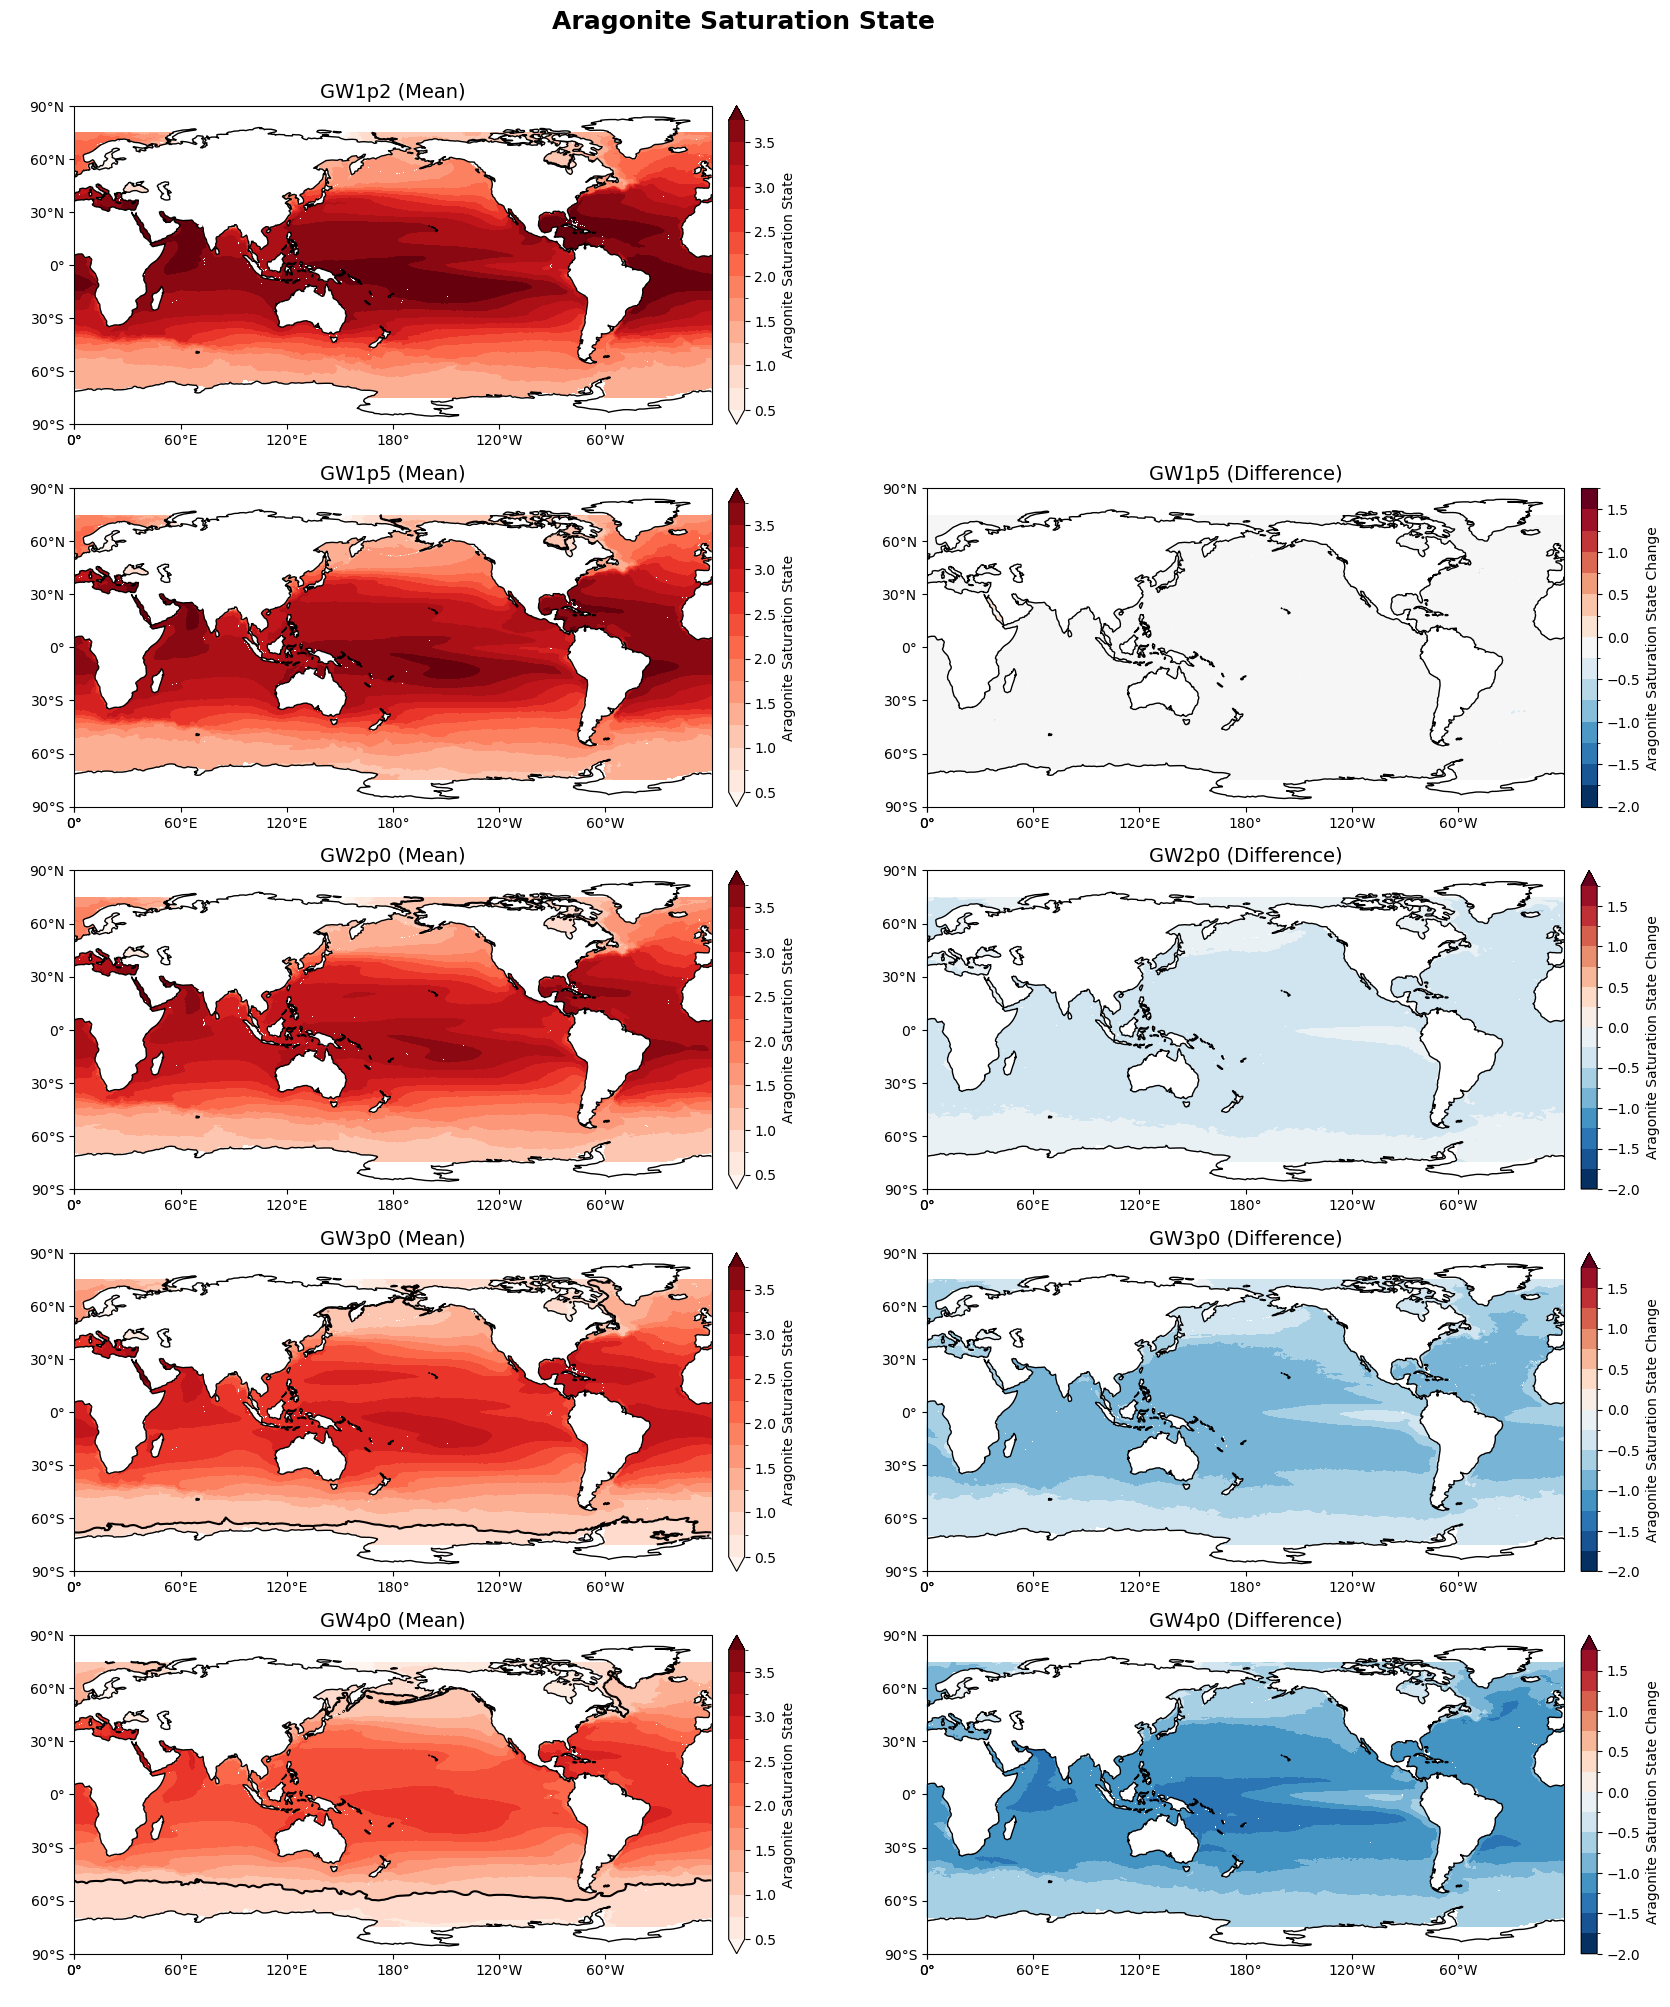

CPU times: user 4min 56s, sys: 1min 53s, total: 6min 50s
Wall time: 4min 27s


In [49]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/OAR_climatology_{period}.nc"
variables = ['OAR']
means,coords=get_data(file_template,variables,periods,True,'month')
#

lev1=np.arange(.5,4,.25)
lev2=np.arange(-2,2,.25)
all_plot('OAR','Aragonite Saturation State',base_period,lev1,lev2,1)

duration
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
GW1p5
GW2p0
GW3p0
GW4p0


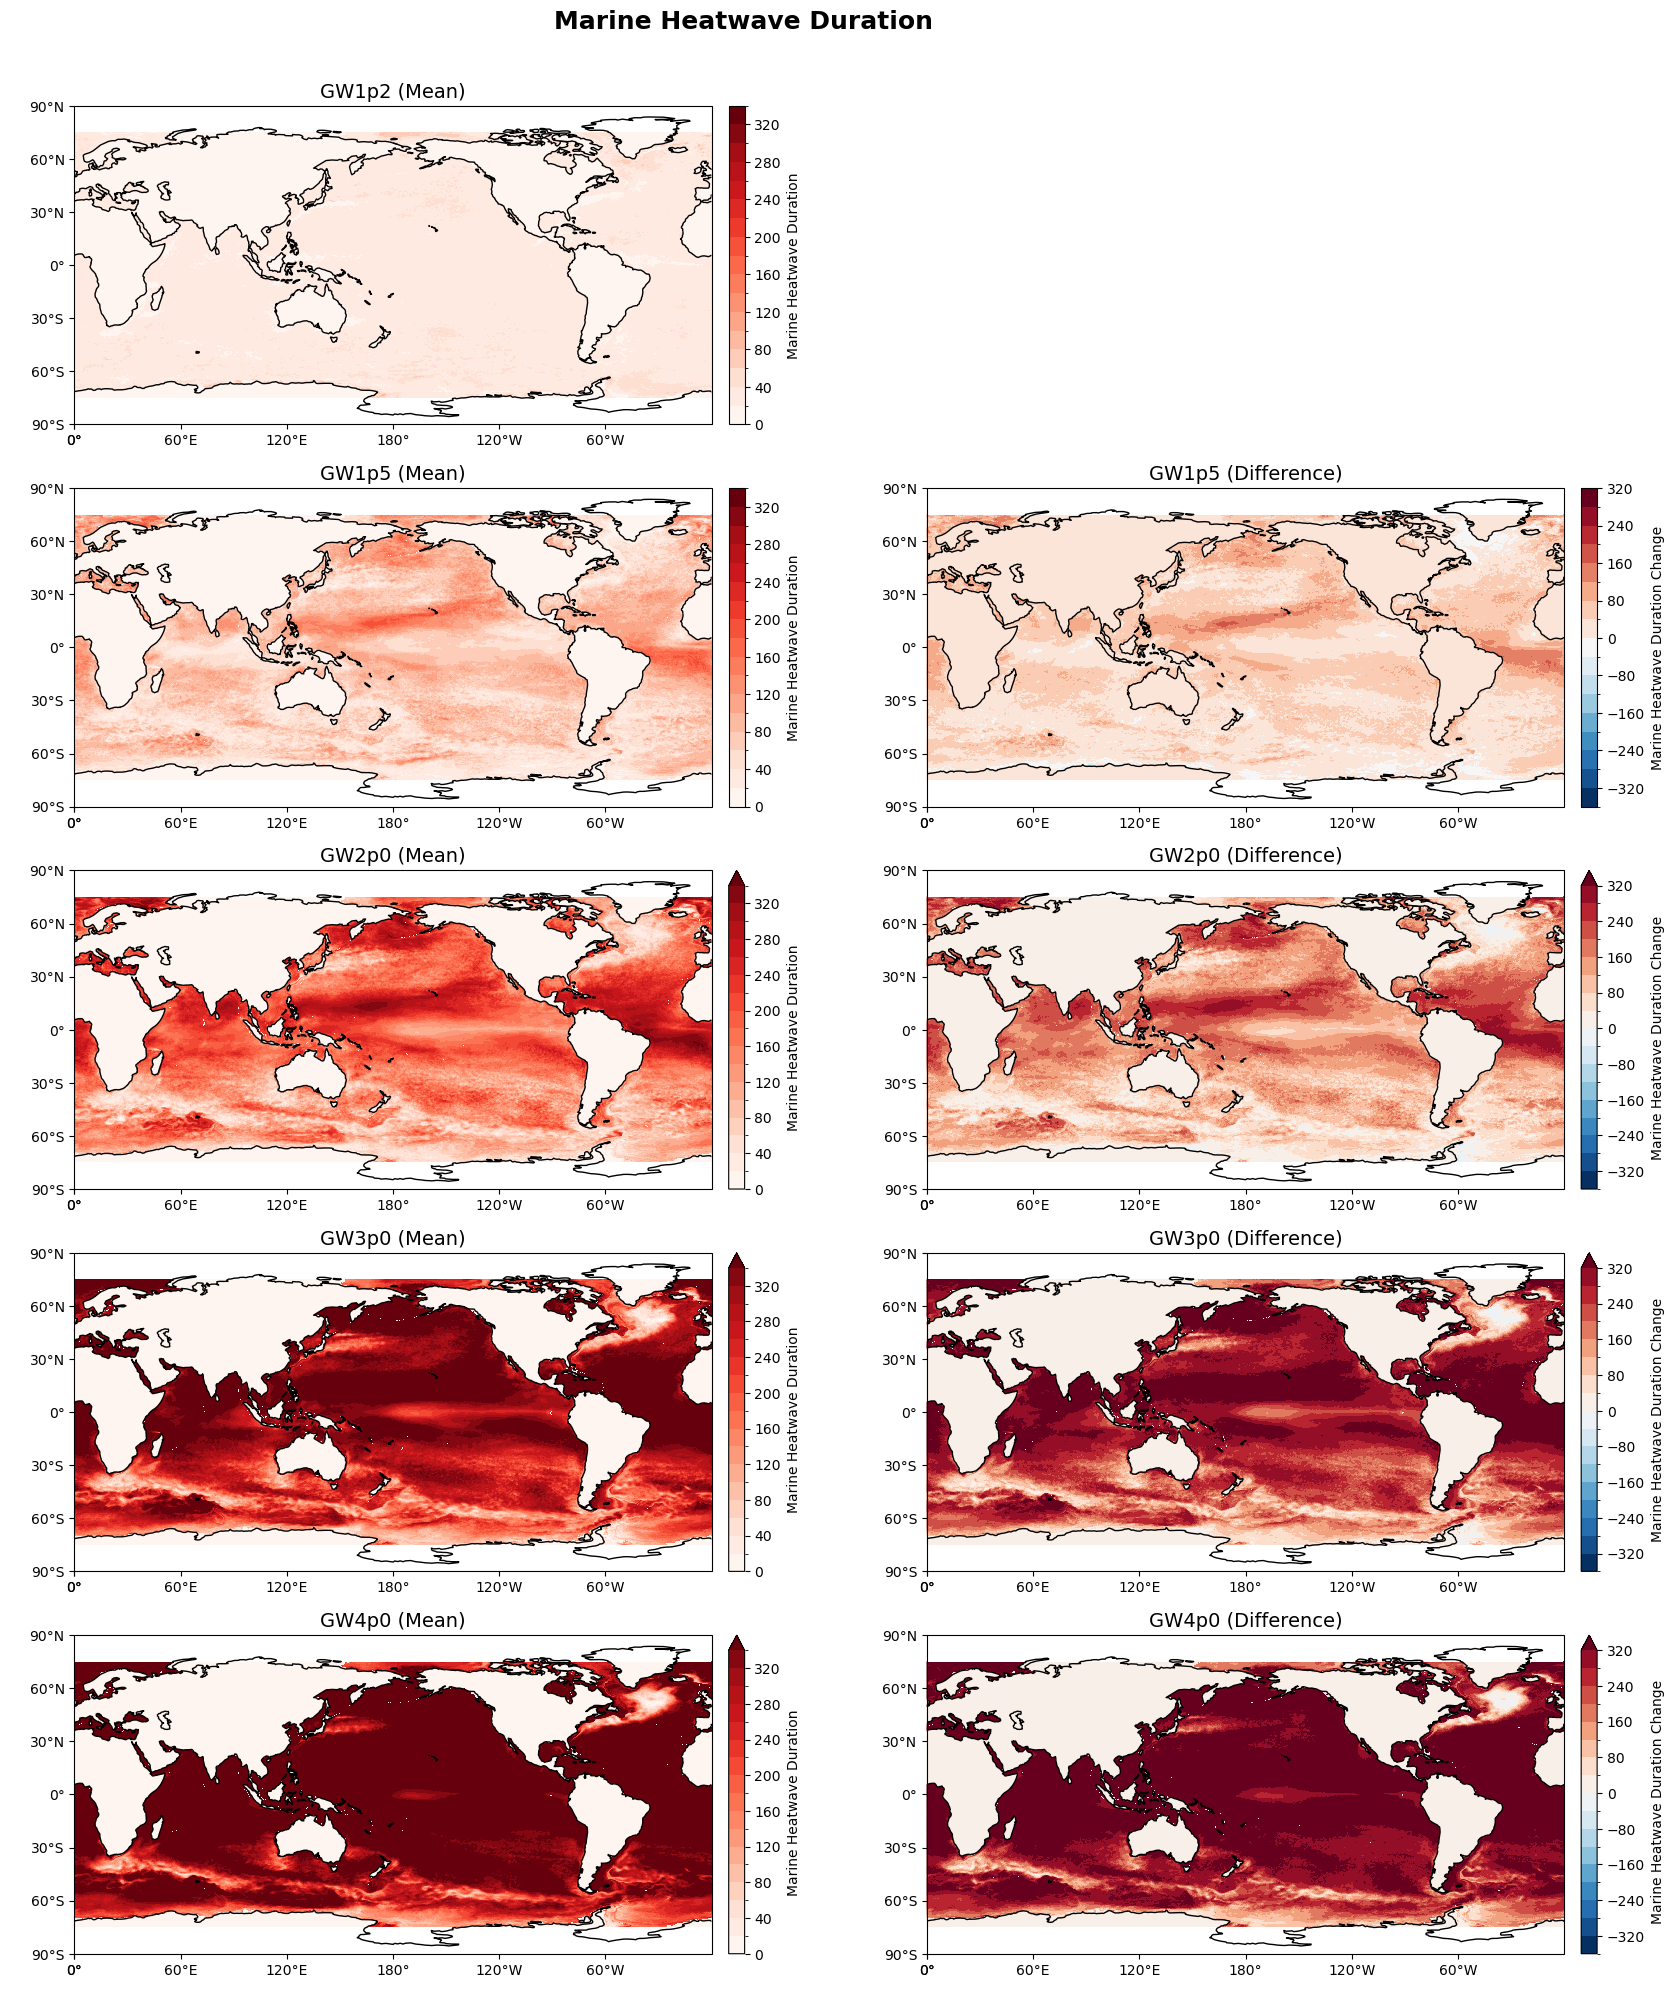

magnitude
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
GW1p5
GW2p0
GW3p0
GW4p0


In [ ]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/{period}_mhw.nc"
variables = ['duration','magnitude']

means,coords=get_data(file_template,variables,periods,False,'year')
means['duration','GW1p2']

lev1=range(0,360,20)
lev2=range(-360,360,40)
all_plot('duration','Marine Heatwave Duration',base_period,lev1,lev2,1)
lev1=np.arange(0,3.5,.5)
lev2=np.arange(-3,3.5,.5)
all_plot('magnitude','Marine Heatwave Magnitude',base_period,lev1,lev2,1)



## End